In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, uniform
import salabim as sim
import seaborn as sns
import enum

In [2]:
class State(enum.Enum):

    in_call = "in call"
    in_list = "in list"
    enter = "enter"
    negotiation = "negotiation"
    issuance = "issuance"
    reject = "rejected"

class WorkType(enum.Enum):

    maintance = {"probabilities": 0.4,
                 "avarage_time": 1.5,
                 "std_time": 0.3,
                 "add_work": True,
                 "inner": False,
                 "time_to_enter": 30, # minutes
                 "time_to_negotiation": 15,
                 "time_to_issuance": 15}
    repair = {"probabilities": 0.4,
              "avarage_time": 2,
              "std_time": 0.3,
              "add_work": False,
              "inner": False,
              "time_to_enter": 15,
              "time_to_negotiation": 0,
              "time_to_issuance": 15}
    diagnostic = {"probabilities": 0.15,
                  "avarage_time": 1,
                  "std_time": 0.3,
                  "add_work": True,
                  "inner": False,
                  "time_to_enter": 30,
                  "time_to_negotiation": 15,
                  "time_to_issuance": 15}
    inner = {"probabilities": 0.05,
                  "avarage_time": 1.5,
                  "std_time": 0.2,
                  "add_work": False,
                  "inner": True,
                  "time_to_enter": 0,
                  "time_to_negotiation": 0,
                  "time_to_issuance": 0}


    def __init__(self, val):
        self.probabilities = val['probabilities']
        self.avarage_time = val['avarage_time']
        self.std_time = val['std_time']
        self.add_work = val['add_work']
        self.inner = val['inner']
        self.time_to_enter = val['time_to_enter']
        self.time_to_negotiation = val['time_to_negotiation']
        self.time_to_issuance = val['time_to_issuance']

    def work_time(self):
        return np.random.normal(loc = self.avarage_time, scale = self.std_time)

class Client(enum.Enum):

    easy = {"probabilities": 0.33,
            "hardness":1,
            "add_work": True}
    norm = {"probabilities": 0.33,
            "hardness": 2,
            "add_work": True}
    hard = {"probabilities": 0.33,
            "hardness": 3,
            "add_work": True}

    def __init__(self, val):
        self.probabilities = val['probabilities']
        self.hardness = val['hardness']
        self.add_work = val['add_work']

class CarVisit:

    def __init__(self, id, WorkType, State = State.in_list, Client=Client.easy, all_times = None ):
        if all_times is None:
            self.all_times = []
        else:
            self.all_times = all_times
        #self.check_out_time = check_out_time
        self.id = id
        self.work_type = WorkType
        self.state = State
        self.client = Client

class Master:

    def __init__(self, level: int): # чем выше разряд тем лучше
        self.level = level

    def process(self, CarVisit):
        status = CarVisit.state # берет из очереди тачку
        type = CarVisit.work_type
        if not type.add_work:
            return 0
        if status == State.enter:
            return 1
        if status == State.negotiation:
            return 2


In [3]:
def discrete_sampler(n, Class):
    probabilities = []
    name_enum = []
    for i in Class:
        probabilities.append(i.value['probabilities'])
        name_enum.append(i.name)
    sample_list = []
    xsi = np.random.uniform(low = 0, high = 1, size = n)
    for num in xsi:
        prob = 0
        flg = 0
        for i in range(len(probabilities)):
            prob += probabilities[i]
            if prob > num and flg == 0:
                sample_list.append(name_enum[i])
                flg = 1
    return sample_list

In [10]:
def check_is_it_possible(n, discritization = 5):
    number = 0
    sample = discrete_sampler(30, WorkType)
    sample_list = np.zeros(n, dtype=int)
    car_v = []
    i_d = 1
    for work_type in sample:

        client = discrete_sampler(1, Client)
        ix = 0
        enter_time = int(WorkType[work_type].time_to_enter / discritization)
        working_time = int(WorkType[work_type].avarage_time * 60 / discritization)
        issuance_time = int(WorkType[work_type].time_to_issuance / discritization)
        while not np.all(sample_list[ix:ix+enter_time] == number):
            ix += 1
            if ix > n-1:
                return car_v
        start_enter_time = ix
        end_enter_time = ix+enter_time
        start_working = end_enter_time
        end_working = start_working + working_time
        sample_list[ix:ix+enter_time] = i_d

        if WorkType[work_type].inner:
            start_neg_time = 0
            end_neg_time = 0
            start_issuance_time = 0
            end_issuance_time = 0
            car = CarVisit(i_d, WorkType[work_type], State.enter, client, [((start_enter_time+1)*discritization, (end_enter_time+1)*discritization),
                                                                           ((start_working+1)*discritization, (end_working+1)*discritization),
                                                                           ((start_neg_time+1)*discritization, (end_neg_time+1)*discritization),
                                                                           ((start_issuance_time+1)*discritization, (end_issuance_time+1)*discritization)])
            car_v.append(car)
            i_d += 1
            continue
        if WorkType[work_type].add_work:
            negotiation_time = int(WorkType[work_type].time_to_negotiation / discritization)
            i = 6
            start_neg_time = ix+enter_time+i
            while not np.all(sample_list[start_neg_time:start_neg_time+negotiation_time+1] == number):
                i += 1
                start_neg_time = ix+enter_time+i
            end_neg_time = start_neg_time+negotiation_time
            sample_list[start_neg_time:end_neg_time] = i_d
        else:
            start_neg_time = -1
            end_neg_time = -1
        while not np.all(sample_list[ix+working_time:ix+working_time+issuance_time+1] == number):
            ix += 1
            if ix > n-1:
                return car_v
        start_issuance_time = ix+working_time
        end_issuance_time = ix+working_time+issuance_time
        sample_list[ix+working_time:ix+working_time+issuance_time] = i_d
        car = CarVisit(i_d, WorkType[work_type], State.enter, client, [((start_enter_time+1)*discritization, (end_enter_time+1)*discritization),
                                                                       ((start_working+1)*discritization, (end_working+1)*discritization),
                                                                       ((start_neg_time+1)*discritization, (end_neg_time+1)*discritization),
                                                                       ((start_issuance_time+1)*discritization, (end_issuance_time+1)*discritization)])
        car_v.append(car)
        i_d += 1
    return car_v

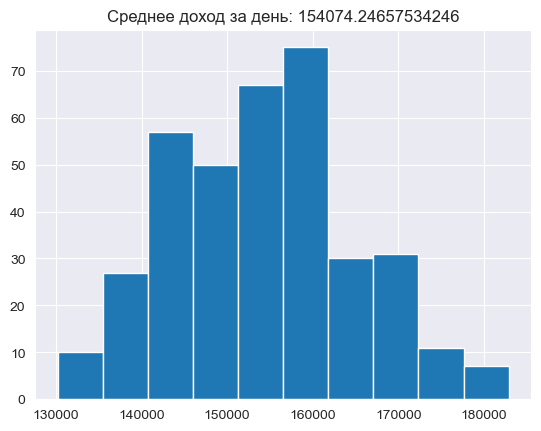

In [38]:
summa_year = np.zeros(365)
for i in range(365):
    resultat = check_is_it_possible(132, discritization = 5)
    summa = 0
    for car in resultat:
        summa += Master(level=1).process(car)
        if car.all_times[2][0] != 0:
            car.state = State.negotiation
            summa += Master(level=1).process(car)
        works = (car.all_times[1][1] - car.all_times[1][0]) / 60
        summa += works
    summa_year[i] = summa*2100 + summa*1000
plt.hist(summa_year);
plt.title(f'Среднее доход за день: {summa_year.mean()}');

In [97]:
working_time = []
for _ in range(2):
    resultat = check_is_it_possible(132, discritization = 5)
    for car in resultat:
        add_time = 0
        add_time += Master(level=1).process(car)
        if car.all_times[2][0] != 0:
            car.state = State.negotiation
            add_time += Master(level=1).process(car)
        start, end = car.all_times[1]
        end += add_time*60
        working_time.append((start, end))
working_time.sort(key=lambda x: x[1])
print(working_time)

[(5, 95), (5, 95), (5, 95), (5, 95), (95, 215), (95, 215), (35, 305), (35, 305), (65, 335), (65, 335), (230, 350), (170, 410), (170, 440), (200, 470), (200, 470), (365, 485), (365, 485), (305, 575), (305, 575), (335, 605), (335, 605), (500, 620), (500, 620), (440, 710), (440, 710), (470, 740), (470, 740), (575, 845), (590, 860), (620, 890), (680, 950)]


In [105]:
class CarVisitGenerator(sim.Component):
    def __init__(self, time_series, *args, **kwargs):
        sim.Component.__init__(self, *args, **kwargs)
        self.time_series = time_series
    def process(self):
        for i in range(len(self.time_series)):
            Car(start = self.time_series[i][0], end = self.time_series[i][1])
            yield self.hold(till=self.time_series[i][1])

class Car(sim.Component):
    def __init__(self, start, end, *args, **kwargs):
        sim.Component.__init__(self, *args, **kwargs)
        self.start = start
        self.end = end
    def process(self):
        self.enter(waitingline)
        for mechanic in mechanics:
            if mechanic.ispassive():
                mechanic.activate()
                break  # activate at most one mechanic
        yield self.passivate()

class Mechanic(sim.Component):
    def process(self):
        while True:
            while len(waitingline) == 0:
                yield self.passivate()
            self.car = waitingline.pop()
            work_time = self.car.end - self.car.start
            yield self.hold(work_time)
            self.car.activate()

env = sim.Environment(trace=True)
CarVisitGenerator(time_series=working_time)
mechanics = [Mechanic() for _ in range(7)]

waitingline = env.Queue("waitingline")

env.run(till=1000)
waitingline.print_histograms()
waitingline.print_info()

line#        time current component    action                               information
------ ---------- -------------------- -----------------------------------  ------------------------------------------------
                                       line numbers refers to               2286267318.py
   33                                  default environment initialize       
   33                                  main create                          
   33       0.000 main                 current                              
    3                                  carvisitgenerator.0 create           
    3                                  carvisitgenerator.0 activate         scheduled for 0.000 @    5  process=process
   35                                  mechanic.0 create                    
   35                                  mechanic.0 activate                  scheduled for 0.000 @   24  process=process
   35                                  mechanic.1 create                